# 02 - Data from the Web

In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

* [Task 1 - Scrape the QS ranking](#Task-1---Scrape-the-QS-ranking)
    * [Best universities for ratio between faculty memebers and students](#Which-are-the-best-universities-in-term-of-ratio-between-faculty-members-and-students-according-to-QS?)
    * [Best universities for the international students ratio](#Which-are-the-best-universities-in-term-of-ratio-of-international-students-according-to-QS?)
    * [Results by region](#Plot-the-results-from-QS-ranking-aggregating-by-region)
    * [Results by country](#Plot-the-results-from-QS-ranking-aggregating-by-country)


* [Task 2 - Scrape the Times ranking](#Task-2---Scrape-the-Times-ranking)
    * [Best universities for ratio between faculty memebers and students](#Which-are-the-best-universities-in-term-of-ratio-between-faculty-members-and-students-according-to-Times?)
    * [Best universities for the international students ratio](#Which-are-the-best-universities-in-term-of-ratio-of-international-students-according-to-Times?)
    * [Results by region](#Plot-the-results-from-Times-ranking-aggregating-by-region)
    * [Results by country](#Plot-the-results-from-Times-ranking-aggregating-by-country)
    
    
* [Task 3 - Merge the dataframes](#Task-3---Merge-the-dataframes)


* [Task 4 - Exploratory analysis](#Task-4---Exploratory-analysis)


* [Task 5 - Exploratory analysis](#Task-5--)

# Imports

In [1]:
# Import libraries
import string
import re
import pickle
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

%matplotlib inline

# Constans definition

In [2]:
QS_RANKING_URL = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
QS_RANKING_JSON = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508104120137'

TIMES_RANKING_URL = 'http://timeshighereducation.com/world-university-rankings/2018/world-ranking'
TIMES_RANKING_JSON = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [3]:
SEARCH_REFERENCE_API = 'https://en.wikipedia.org/w/api.php?action=query&titles={0}&prop=revisions&rvprop=content&format=json&indexpageids'

During the very first scraping, we build a table that links a country to a specific region. This information is available in the QS ranking and will be used to fill the Times dataframe.

Once the first scraping is done, the table (along with the two rankings) are serialized in local for future runs

In [4]:
try:
    COUNTRY_REGION_METADATA = pd.read_pickle('serial/country_region_metadata.p')
except (OSError, IOError) as e:
    COUNTRY_REGION_METADATA = pd.DataFrame(columns=['Region'])
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')

In [5]:
COUNTRY_REGION_METADATA

,Region
United States,North America
United Kingdom,Europe
Switzerland,Europe
Singapore,Asia
Australia,Oceania
China,Asia
Hong Kong,Asia
Japan,Asia
Canada,North America
South Korea,Asia


# General use functions definition

In [6]:
def build_html_parser(url):
    '''
    Function to build a parser object of type BeautifulSoup
    
    url      the webpage url to which send a get request to
    
    return   a parser of the given webpage
    '''
    
    r = requests.get(url)
    page_body = r.text
    
    soup = BeautifulSoup(page_body, 'html.parser')
    
    return soup

In [7]:
def clean_str_number(str_n):
    
    return str_n.strip('\n').strip('%').replace(',', '')

In [8]:
def search_standard_name(str_name):
    
    str_name = str_name.split(" - ")[0] # Manage name with - (short)
    str_name = str_name.split(" – ")[0] # Manage name with – (long)
    str_name = re.sub('\(.*?\)','', str_name) # no brackets
    str_name = str_name.strip().replace('&', '%26')
    
    #r = requests.get(SEARCH_REFERENCE_API.format(str_name.strip().replace(' ', '%20')))
    r = requests.get(SEARCH_REFERENCE_API.format(str_name.strip().replace(' ', '_')))
    data = r.json()
    
    page_id = data['query']['pageids'][0]
    
    if (page_id == '-1'):
        print('Not found :( -> {}'.format(str_name))
        
        # Manually set a standard name for the only unmatchable university. 
        # We have a total of 9 unknown sources during the WikiData requests, but only one university appears twice
        # and it need to receive a standard name to be merged later on. The other onces could keep their name
        if (str_name == "Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento"):
            found_name = "Scuola Superiore Sant’Anna"
        else:
            found_name = str_name
    else:
        found_name = data['query']['pages'][page_id]['title']
        
    return(found_name)

In [9]:
def update_country_region_metadata(country, region):
    
    global COUNTRY_REGION_METADATA
    
    if (country in COUNTRY_REGION_METADATA.index):
        return
    
    new_row = pd.Series(region, index=['Region'])
    new_row.name = country
    
    COUNTRY_REGION_METADATA = COUNTRY_REGION_METADATA.append(new_row)

## Task 1 - Scrape the QS ranking
Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018)

In [10]:
# TODO: Handled the returning value for data not found. 
# Atm I return a -1, but this fucks up the plotting and computation for the ratios

def parse_detail_page(url_detail):
    '''
    Function that parses the missing informations from the detail page of the university from the QS website
    
    Return   a dictionary with all the data found as integers values
    '''
    
    # Build a parser for the detail page
    soup = build_html_parser(url_detail)
    
    # Obtain and clean up the total faculty member value
    try:
        faculty_member_total = soup.find('div', class_='total faculty').find('div', class_='number').text
        faculty_member_total = clean_str_number(faculty_member_total)
    except:
        faculty_member_total = -1
    
    
    # Obtain and clean up the international faculty member value
    try:
        faculty_member_inter = soup.find('div', class_='inter faculty').find('div', class_='number').text.strip('\n')
        faculty_member_inter = clean_str_number(faculty_member_inter)
    except:
        faculty_member_inter = -1
    
    # Obtain and clean up the total students value
    try:
        student_total = soup.find('div', class_='total student').find('div', class_='number').text.strip('\n')
        student_total = clean_str_number(student_total)
    except:
        student_total = -1
    
    # Obtain and clean up the international students value
    try:
        student_inter = soup.find('div', class_='total inter').find('div', class_='number').text.strip('\n')
        student_inter = clean_str_number(student_inter)
    except:
        student_inter = -1
    
    # Build a dictionary for the parsed informations
    detail_info = {'Total faculty member' : int(faculty_member_total), 
                   'International faculty member' : int(faculty_member_inter), 
                   'Total student' : int(student_total), 
                   'International student' : int(student_inter)
                  }
    
    return detail_info

After some work on the Postman Inspector, we found out that the GET Request made to the QS website ended up with multiple attached files to go with the response. One of those files was a JSON with all the infos from the ranking.

In [11]:
req = requests.get(QS_RANKING_JSON)
data_from_url = req.json()

Such data is stored as a list of dictionaries, as visible in the example below:

In [12]:
print('First cell:')
print(data_from_url['data'][0], end='\n\n')

print('Second cell:')
print(data_from_url['data'][1], end='\n\n')

print('...')

First cell:
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}

Second cell:
{'nid': '297282', 'url': '/universities/stanford-university', 'title': 'Stanford University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/stanford-university_573_small_0.jpg" alt="Stanford University Logo">', 'core_id': '573', 'score': '98.7', 'rank_display': '2', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a h

In [13]:
def scrape_qs_ranking():
    '''
    Obtain the ranking from QS in a dataframe
    '''
    
    r = requests.get(QS_RANKING_JSON)
    data = r.json()
    
    university_list = []

    # Iterate throu the first 200 elments of the list
    for i, d in enumerate(data['data'][:200]):
    
        # Store the parsed information into a dictionary ---- d['rank_display']
        info = {'Rank': (i+1), 
                'University name': search_standard_name(d['title']), 
                'Country': d['country'],
                'Region' : d['region']
               }
    
        update_country_region_metadata(d['country'], d['region'])
    
        # Extend the dictionary with the informations in the detail page
        url_detail = 'https://www.topuniversities.com' +  d['url']
        info.update( parse_detail_page( url_detail))
    
        university_list.append(info)
    
    # After scraping data from QS ranking the metadata dataframe needs to be stored updated
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')
    
    qs_ranking_df = pd.DataFrame.from_dict(university_list)
    return qs_ranking_df

In [14]:
try:
    qs_ranking_df = pd.read_pickle('serial/qs_save.p')
except (OSError, IOError) as e:
    qs_ranking_df = scrape_qs_ranking()
    qs_ranking_df.to_pickle('serial/qs_save.p')
    
qs_ranking_df.head()

,Country,International faculty member,International student,Rank,Region,Total faculty member,Total student,University name
0,United States,1679,3717,1,North America,2982,11067,Massachusetts Institute of Technology
1,United States,2042,3611,2,North America,4285,15878,Stanford University
2,United States,1311,5266,3,North America,4350,22429,Harvard University
3,United States,350,647,4,North America,953,2255,California Institute of Technology
4,United Kingdom,2278,6699,5,Europe,5490,18770,University of Cambridge


In [15]:
qs_ranking_df.set_index(['University name'], inplace=True)

### Which are the best universities in term of ratio between faculty members and students according to QS?

In [16]:
# Compute the ratio between faculty member and students
qs_ranking_df['Faculty/students ratio'] = qs_ranking_df['Total faculty member'] / qs_ranking_df['Total student']

# Clean up the computation taking care of unknown values (previously set at -1)
qs_fsratio_defined = (qs_ranking_df['Total faculty member'] != -1) | (qs_ranking_df['Total student'] != -1)
qs_ranking_df.loc[~qs_fsratio_defined, 'Faculty/students ratio'] = -1

# Define a dataset for the result computation
qs_faculty_students_rank_df = qs_ranking_df[['Country', 'Region', 'Total faculty member', 'Total student', 'Faculty/students ratio']]
qs_faculty_students_rank_df = qs_faculty_students_rank_df.sort_values('Faculty/students ratio', ascending=False)

qs_faculty_students_rank_df.head()

,Country,Region,Total faculty member,Total student,Faculty/students ratio
University name,,,,,
California Institute of Technology,United States,North America,953,2255,0.422616
Yale University,United States,North America,4940,12402,0.398323
University of Oxford,United Kingdom,Europe,6750,19720,0.342292
University of Cambridge,United Kingdom,Europe,5490,18770,0.292488
Johns Hopkins University,United States,North America,4462,16146,0.276353


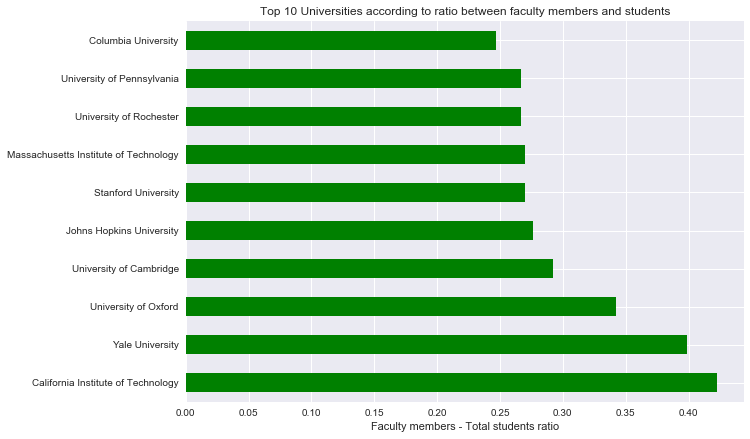

In [17]:
qs_faculty_students_rank_df[:10]['Faculty/students ratio'].plot(kind='barh', figsize=(10,7), color='green')

plt.title('Top 10 Universities according to ratio between faculty members and students')
#plt.xticks(rotation = 90 if (len(group) > 5) else 0)
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

### Which are the best universities in term of ratio of international students according to QS?

In [18]:
# Compute the ratio of international students
qs_ranking_df['Intern/student ratio'] = qs_ranking_df['International student'] / qs_ranking_df['Total student']

# Clean up the computation taking care of unknown values (previously set at -1)
qs_isratio_defined = (qs_ranking_df['International student'] != -1) | (qs_ranking_df['Total student'] != -1)
qs_ranking_df.loc[~qs_isratio_defined, 'Intern/student ratio'] = -1

# Define a dataset for the result computation
qs_international_students_rank_df = qs_ranking_df[['Country', 'Region', 'International student', 'Total student', 'Intern/student ratio']]
qs_international_students_rank_df = qs_international_students_rank_df.sort_values('Intern/student ratio', ascending=False)

qs_international_students_rank_df.head()

,Country,Region,International student,Total student,Intern/student ratio
University name,,,,,
London School of Economics and Political Science,United Kingdom,Europe,6748,9760,0.691393
Ecole Polytechnique Fédérale de Lausanne,Switzerland,Europe,5896,10343,0.570047
Imperial College London,United Kingdom,Europe,8746,16090,0.543567
Maastricht University,Netherlands,Europe,8234,16385,0.502533
Carnegie Mellon University,United States,North America,6385,13356,0.478062


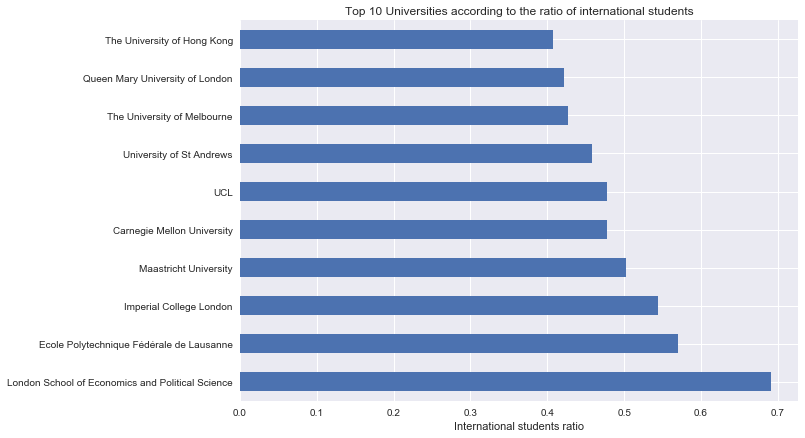

In [19]:
qs_international_students_rank_df[:10]['Intern/student ratio'].plot(kind='barh', figsize=(10,7))

plt.title('Top 10 Universities according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

### Plot the results from QS ranking aggregating by region

For the faculty to student ratio:

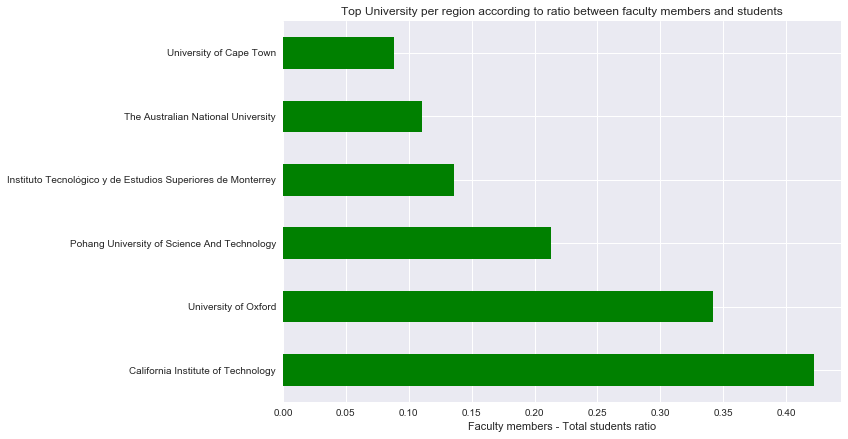

In [20]:
qs_facutly_student_ratio_by_region_df = qs_faculty_students_rank_df.groupby('Region').head(1)
qs_facutly_student_ratio_by_region_df['Faculty/students ratio'].plot(kind='barh',figsize=(10,7),  color='green')

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

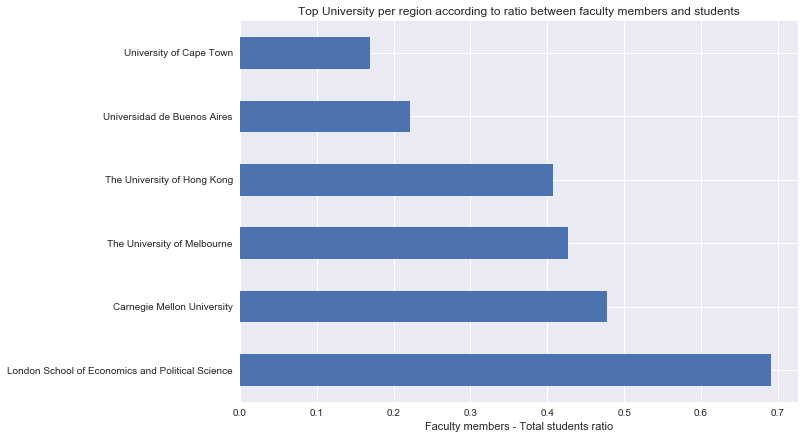

In [21]:
qs_international_students_ratio_by_region_df = qs_international_students_rank_df.groupby('Region').head(1)
qs_international_students_ratio_by_region_df['Intern/student ratio'].plot(kind='barh', figsize=(10,7))

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

### Plot the results from QS ranking aggregating by country

For the faculty to student ratio:

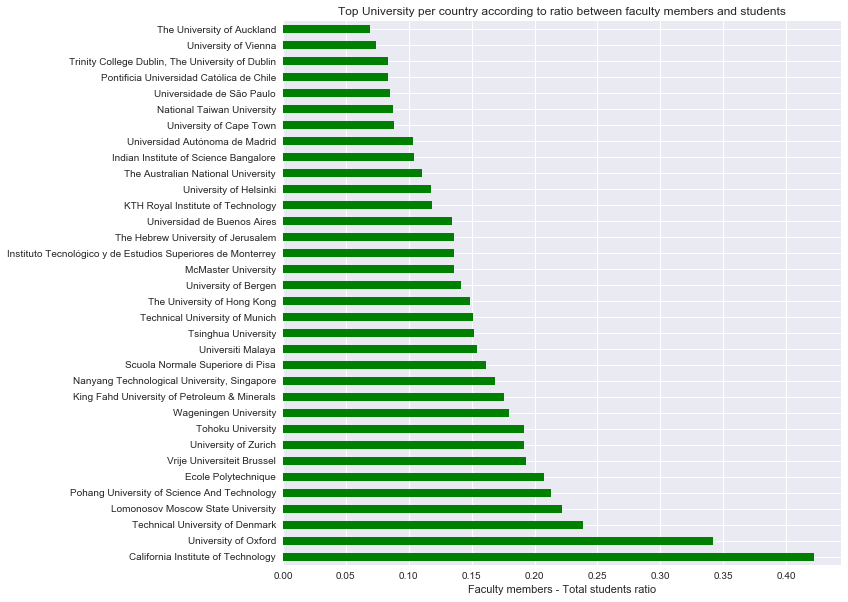

In [22]:
qs_facutly_student_ratio_by_country_df = qs_faculty_students_rank_df.groupby('Country').head(1)
qs_facutly_student_ratio_by_country_df['Faculty/students ratio'].plot(kind='barh', figsize=(10,10), color='green')

plt.title('Top University per country according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

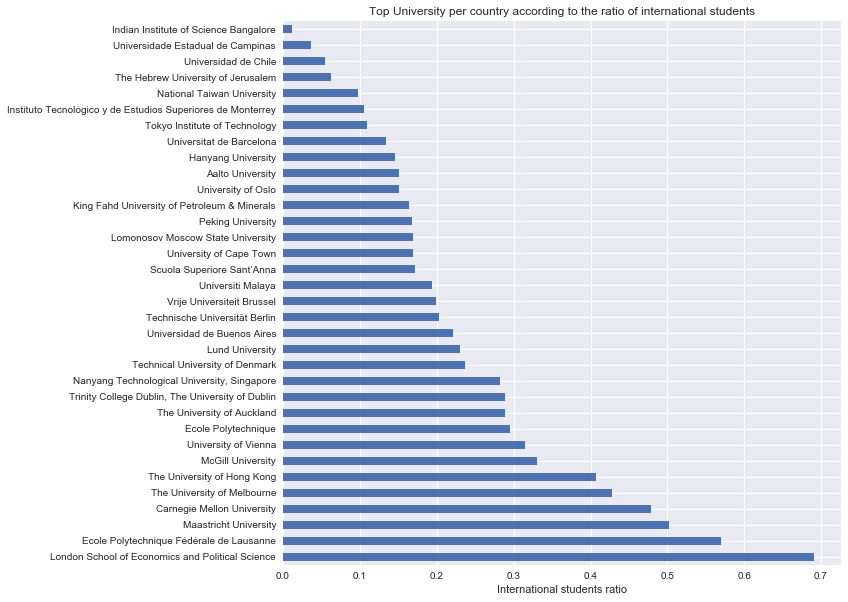

In [23]:
qs_international_students_ratio_by_country_df = qs_international_students_rank_df.groupby('Country').head(1)
qs_international_students_ratio_by_country_df['Intern/student ratio'].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per country according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

## Task 2 - Scrape the Times ranking
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

In [24]:
def compute_value_from_percentage(total, percentage):
    
    total = int( total )
    percentage = float( percentage )
    
    return round( (total/100) * percentage )

In [25]:
def compute_value_from_proportion(total, proportion):
    
    total = int( total )
    proportion = float( proportion )
    
    return round( total / proportion )

In [26]:
def scrape_times_ranking():
    '''
    Obtain the ranking from Times in a dataframe
    '''

    r = requests.get(TIMES_RANKING_JSON)
    data = r.json()

    university_list = []

    # Iterate throu the first 200 elments of the list
    for i, d in enumerate(data['data'][:200]):
    
        # Preliminary computations to extract data
        intern_student = compute_value_from_percentage( clean_str_number( d['stats_number_students']), 
                                                       clean_str_number( d['stats_pc_intl_students'])
                                                      )
    
        faculty_member_total = compute_value_from_proportion( clean_str_number( d['stats_number_students']), 
                                                             clean_str_number( d['stats_student_staff_ratio'])
                                                            )
        
        # Determine region from the data of the QS ranking stored in the metadata
        try:
            region = COUNTRY_REGION_METADATA.get_value(d['location'], 'Region')
        except:
            region = 'NaN'
    
        # Store the parsed information into a dictionary
        info = {'Rank': (i+1), 
                'University name': search_standard_name(d['name']), 
                'Country': d['location'],
                'Region' : region,
                'Total student' : int(clean_str_number( d['stats_number_students'])),
                'International student' : int(intern_student),
                'Total faculty member' : int(faculty_member_total)
               }
    
        university_list.append(info)
   
    times_ranking_df = pd.DataFrame.from_dict(university_list)
    return times_ranking_df

In [27]:
try:
    times_ranking_df = pd.read_pickle('serial/times_save.p')
except (OSError, IOError) as e:
    times_ranking_df = scrape_times_ranking()
    times_ranking_df.to_pickle('serial/times_save.p')
    
times_ranking_df.head()

Not found :( -> Wageningen University %26 Research
Not found :( -> Paris Sciences et Lettres
Not found :( -> Scuola Superiore Sant’Anna


,Country,International student,Rank,Region,Total faculty member,Total student,University name
0,United Kingdom,7755,1,Europe,1822,20409,University of Oxford
1,United Kingdom,6436,2,Europe,1687,18389,University of Cambridge
2,United States,596,3,North America,340,2209,California Institute of Technology
3,United States,3486,4,North America,2113,15845,Stanford University
4,United States,3800,5,North America,1285,11177,Massachusetts Institute of Technology


In [28]:
times_ranking_df.set_index(['University name'], inplace=True)

In [29]:
times_ranking_df[times_ranking_df.index == "Paris"]

,Country,International student,Rank,Region,Total faculty member,Total student
University name,,,,,,


Even after extrapolating the region information from the first dataset, we might have some missing data. Those will be manually handled to fix the table

In [30]:
times_ranking_df[times_ranking_df['Region'] == 'NaN']

,Country,International student,Rank,Region,Total faculty member,Total student
University name,,,,,,
University of Luxembourg,Luxembourg,2832,179,NaN,340,4969
Lomonosov Moscow State University,Russian Federation,6432,194,NaN,4005,29236


In [31]:
times_ranking_df.set_value('University of Luxembourg', 'Region', 'Europe')
times_ranking_df.set_value('Lomonosov Moscow State University', 'Region', 'Europe')

times_ranking_df[times_ranking_df['Country'] == 'Luxembourg']

,Country,International student,Rank,Region,Total faculty member,Total student
University name,,,,,,
University of Luxembourg,Luxembourg,2832,179,Europe,340,4969


### Which are the best universities in term of ratio between faculty members and students according to Times?

In [32]:
# Compute the ratio between faculty member and students
times_ranking_df['Faculty/students ratio'] = times_ranking_df['Total faculty member'] / times_ranking_df['Total student']

# Clean up the computation taking care of unknown values (previously set at -1)
times_isratio_defined = (times_ranking_df['Total faculty member'] != -1) | (times_ranking_df['Total student'] != -1)
times_ranking_df.loc[~times_isratio_defined, 'Faculty/students ratio'] = -1

# Define a dataset for the result computation
times_faculty_students_rank_df = times_ranking_df[['Country', 'Region', 'Total faculty member', 'Total student', 'Faculty/students ratio']]
times_faculty_students_rank_df = times_faculty_students_rank_df.sort_values('Faculty/students ratio', ascending=False)

times_faculty_students_rank_df.head()

,Country,Region,Total faculty member,Total student,Faculty/students ratio
University name,,,,,
Vanderbilt University,United States,North America,3640,12011,0.303056
University of Copenhagen,Denmark,Europe,7413,30395,0.243889
Yale University,United States,North America,2827,12155,0.232579
University of Rochester,United States,North America,2241,9636,0.232565
Johns Hopkins University,United States,North America,3604,15498,0.232546


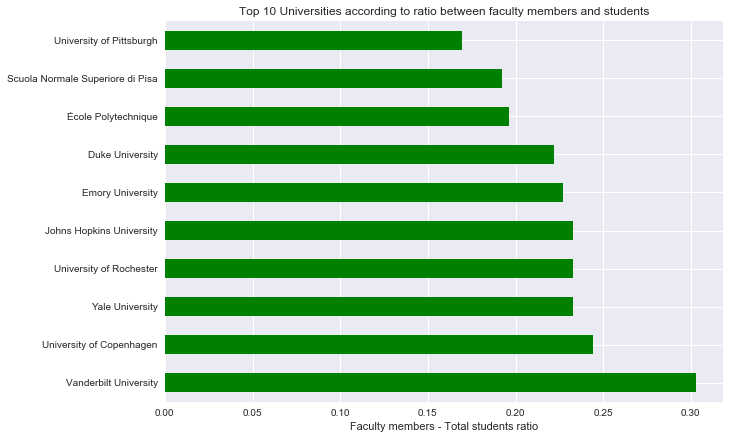

In [33]:
times_faculty_students_rank_df[:10]['Faculty/students ratio'].plot(kind='barh', figsize=(10,7), color='green')

plt.title('Top 10 Universities according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

### Which are the best universities in term of ratio of international students according to Times?

In [34]:
# Compute the ratio of international students
times_ranking_df['Intern/student ratio'] = times_ranking_df['International student'] / times_ranking_df['Total student']

# Clean up the computation taking care of unknown values (previously set at -1)
times_isratio_defined = (times_ranking_df['International student'] != -1) | (times_ranking_df['Total student'] != -1)
times_ranking_df.loc[~times_isratio_defined, 'Intern/student ratio'] = -1

# Define a dataset for the result computation
times_international_students_rank_df = times_ranking_df[['Country', 'Region', 'International student', 'Total student', 'Intern/student ratio']]
times_international_students_rank_df = times_international_students_rank_df.sort_values('Intern/student ratio', ascending=False)

times_international_students_rank_df.head()

,Country,Region,International student,Total student,Intern/student ratio
University name,,,,,
London School of Economics and Political Science,United Kingdom,Europe,7146,10065,0.709985
University of Luxembourg,Luxembourg,Europe,2832,4969,0.569934
Imperial College London,United Kingdom,Europe,8721,15857,0.549978
École Polytechnique Fédérale de Lausanne,Switzerland,Europe,5460,9928,0.549960
Maastricht University,Netherlands,Europe,8364,16727,0.500030


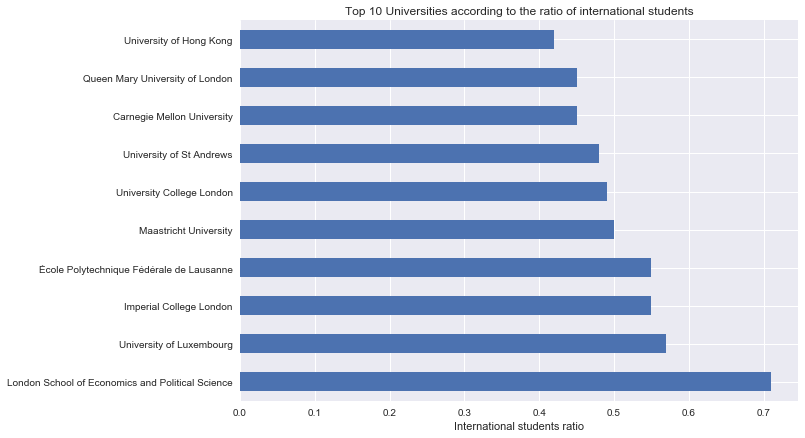

In [35]:
times_international_students_rank_df[:10]['Intern/student ratio'].plot(kind='barh', figsize=(10,7))

plt.title('Top 10 Universities according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

### Plot the results from Times ranking aggregating by region

For the faculty to student ratio:

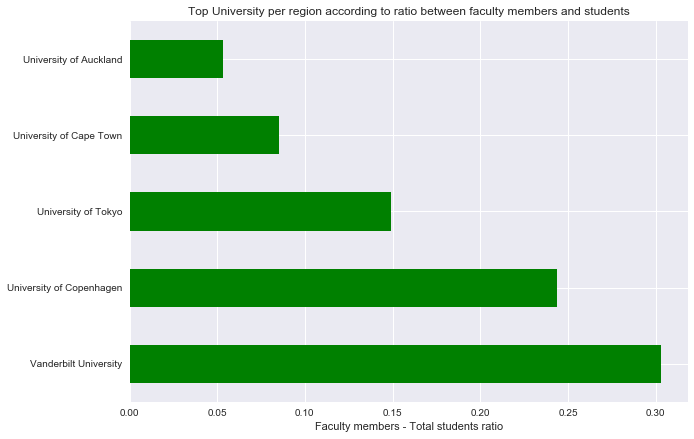

In [36]:
times_facutly_student_ratio_by_region_df = times_faculty_students_rank_df.groupby('Region').head(1)
times_facutly_student_ratio_by_region_df['Faculty/students ratio'].plot(kind='barh',figsize=(10,7),  color='green')

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

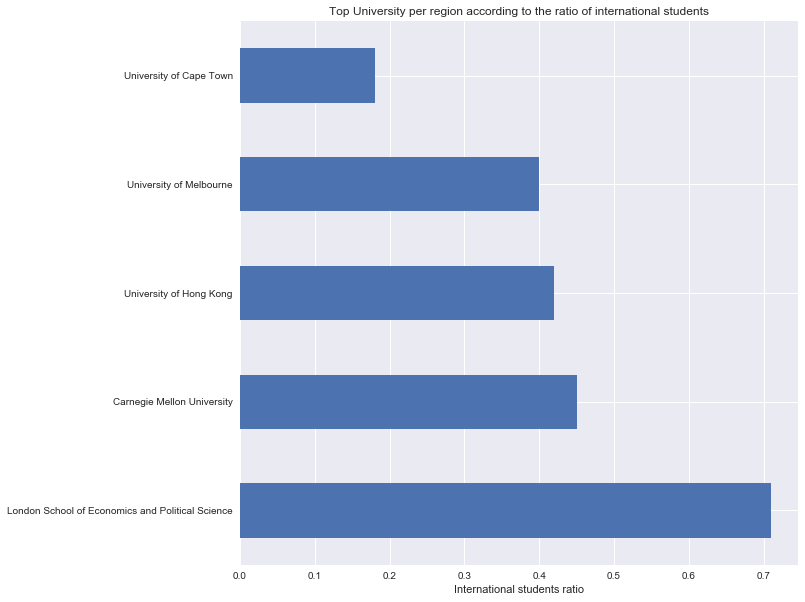

In [37]:
times_international_students_ratio_by_region_df = times_international_students_rank_df.groupby('Region').head(1)
times_international_students_ratio_by_region_df['Intern/student ratio'].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per region according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

### Plot the results from Times ranking aggregating by country

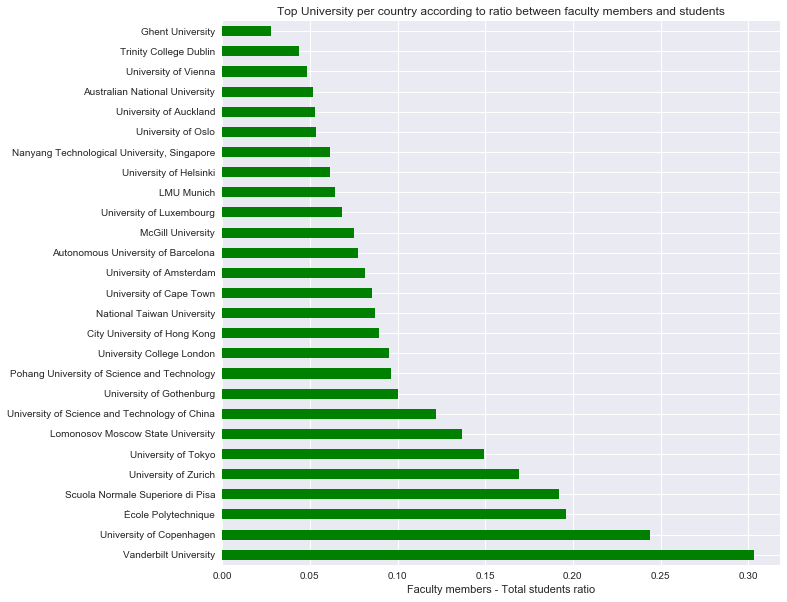

In [38]:
times_facutly_student_ratio_by_country_df = times_faculty_students_rank_df.groupby('Country').head(1)
times_facutly_student_ratio_by_country_df['Faculty/students ratio'].plot(kind='barh', figsize=(10,10), color='green')

plt.title('Top University per country according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

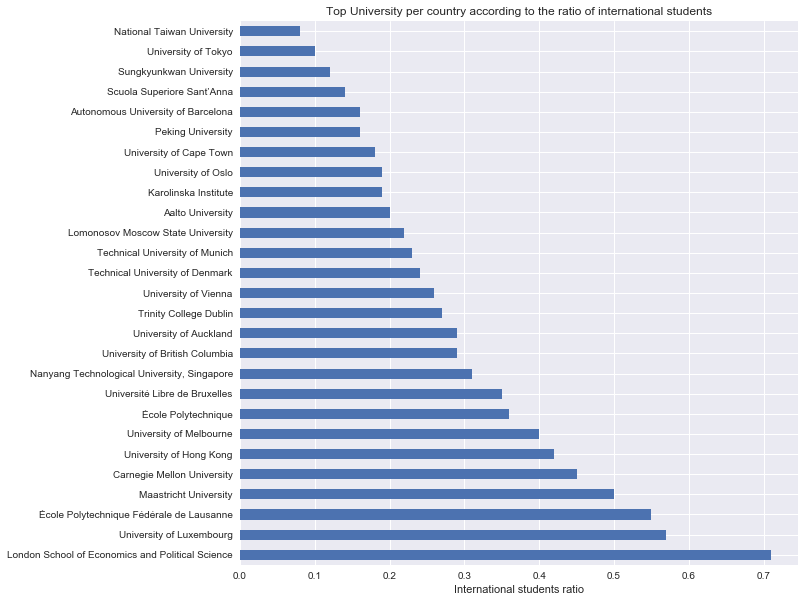

In [39]:
times_international_students_ratio_by_country_df = times_international_students_rank_df.groupby('Country').head(1)
times_international_students_ratio_by_country_df['Intern/student ratio'].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per country according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

## Task 3 - Merge the dataframes
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

Merging is trivial because we have already handled the standardization of University Names during the scapring task. Since both rankings have names from the WikiData database, merging gives a perfect result. We first do some riorganization of the two dataframes as follows

In [40]:
# Obtain a column for the university name on which do the merging
qs_ranking_df['University name'] = qs_ranking_df.index
times_ranking_df['University name'] = times_ranking_df.index

In [41]:
# Clean up the values in QS ranking for perfect merge
qs_ranking_df['University name'] = qs_ranking_df['University name'].str.strip()
qs_ranking_df['Country'] = qs_ranking_df['Country'].str.strip()

# Clean up the values in Times ranking for perfect merge
times_ranking_df['University name'] = times_ranking_df['University name'].str.strip()
times_ranking_df['Country'] = times_ranking_df['Country'].str.strip()

Then merging the two dataframes into one

In [42]:
# Merge the dataframes via an outer join on the cols name, country and region
merged_ranking_df = pd.merge(qs_ranking_df, times_ranking_df, 
                             on=['University name', 'Country', 'Region'], 
                             how='outer', 
                             suffixes=('_QS', '_TM')
                            )

# Use the University Name as an index for the merged dataframe too
merged_ranking_df.set_index(['University name'], inplace=True)

merged_ranking_df.head()

,Country,International faculty member,International student_QS,Rank_QS,Region,Total faculty member_QS,Total student_QS,Faculty/students ratio_QS,Intern/student ratio_QS,International student_TM,Rank_TM,Total faculty member_TM,Total student_TM,Faculty/students ratio_TM,Intern/student ratio_TM
University name,,,,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1679.0,3717.0,1.0,North America,2982.0,11067.0,0.269450,0.335863,3800.0,5.0,1285.0,11177.0,0.114968,0.339984
Stanford University,United States,2042.0,3611.0,2.0,North America,4285.0,15878.0,0.269870,0.227422,3486.0,4.0,2113.0,15845.0,0.133354,0.220006
Harvard University,United States,1311.0,5266.0,3.0,North America,4350.0,22429.0,0.193945,0.234785,5285.0,6.0,2284.0,20326.0,0.112368,0.260012
California Institute of Technology,United States,350.0,647.0,4.0,North America,953.0,2255.0,0.422616,0.286918,596.0,3.0,340.0,2209.0,0.153916,0.269805
University of Cambridge,United Kingdom,2278.0,6699.0,5.0,Europe,5490.0,18770.0,0.292488,0.356899,6436.0,2.0,1687.0,18389.0,0.091740,0.349992


Optimize the data

In [43]:
for x in ['Total student', 'International student', 'Total faculty member', 'Faculty/students ratio', 'Intern/student ratio']:
    merged_ranking_df[x] = merged_ranking_df[['{0}_{1}'.format(x, 'QS'), '{0}_{1}'.format(x, 'TM')]].mean(axis=1)
    merged_ranking_df.drop(['{0}_{1}'.format(x, 'QS'), '{0}_{1}'.format(x, 'TM')], axis=1, inplace=True)

Sample of the final result:

In [44]:
merged_ranking_df.head()

,Country,International faculty member,Rank_QS,Region,Rank_TM,Total student,International student,Total faculty member,Faculty/students ratio,Intern/student ratio
University name,,,,,,,,,,
Massachusetts Institute of Technology,United States,1679.0,1.0,North America,5.0,11122.0,3758.5,2133.5,0.192209,0.337924
Stanford University,United States,2042.0,2.0,North America,4.0,15861.5,3548.5,3199.0,0.201612,0.223714
Harvard University,United States,1311.0,3.0,North America,6.0,21377.5,5275.5,3317.0,0.153157,0.247399
California Institute of Technology,United States,350.0,4.0,North America,3.0,2232.0,621.5,646.5,0.288266,0.278362
University of Cambridge,United Kingdom,2278.0,5.0,Europe,2.0,18579.5,6567.5,3588.5,0.192114,0.353446


## Task 4 - Exploratory analysis

It is interesting to see how the top universities are distributed among the continents. Nearly half of these top universities are in Europe, and around one fourth of them are in North America.

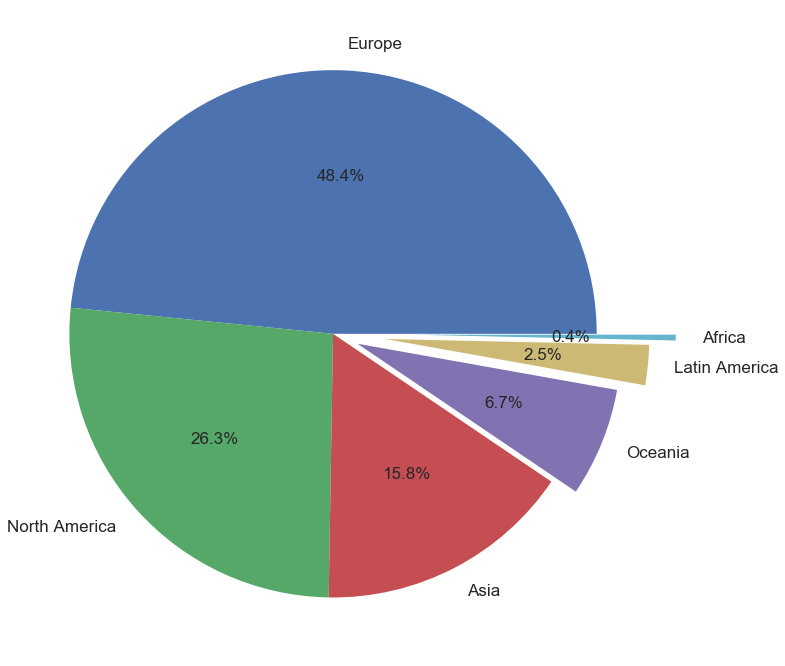

In [45]:
explode = (0, 0, 0, 0.1, 0.2, 0.3)
merged_ranking_df['Region'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(12,12),fontsize=17, explode = explode)

plt.ylabel("")
plt.axis('equal')
plt.show()

We can then classify the universities according to their size. We are considering that their size is determined by the number of students, with the same classification that was used for the QS ranking (Described [here](http://www.iu.qs.com/university-rankings/qs-classifications/)).

In [46]:
def university_sizes(x):
    """Returns a size label based on the number of students."""
    if not x:
        return None
    else:
        return ('Small' if x < 5000 else 'Medium' if x < 12000
                else 'Large' if x < 30000 else 'Extra Large')

In [47]:
merged_ranking_df['Size'] = merged_ranking_df['Total student'].apply(lambda x: university_sizes(x))
merged_ranking_df.head()

,Country,International faculty member,Rank_QS,Region,Rank_TM,Total student,International student,Total faculty member,Faculty/students ratio,Intern/student ratio,Size
University name,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1679.0,1.0,North America,5.0,11122.0,3758.5,2133.5,0.192209,0.337924,Medium
Stanford University,United States,2042.0,2.0,North America,4.0,15861.5,3548.5,3199.0,0.201612,0.223714,Large
Harvard University,United States,1311.0,3.0,North America,6.0,21377.5,5275.5,3317.0,0.153157,0.247399,Large
California Institute of Technology,United States,350.0,4.0,North America,3.0,2232.0,621.5,646.5,0.288266,0.278362,Small
University of Cambridge,United Kingdom,2278.0,5.0,Europe,2.0,18579.5,6567.5,3588.5,0.192114,0.353446,Large


When we look at the proportions of top universities according to their size, it is interesting to see that over 80% of them have more than 30,000 students - and out of these, 30% are considered to be extra large.

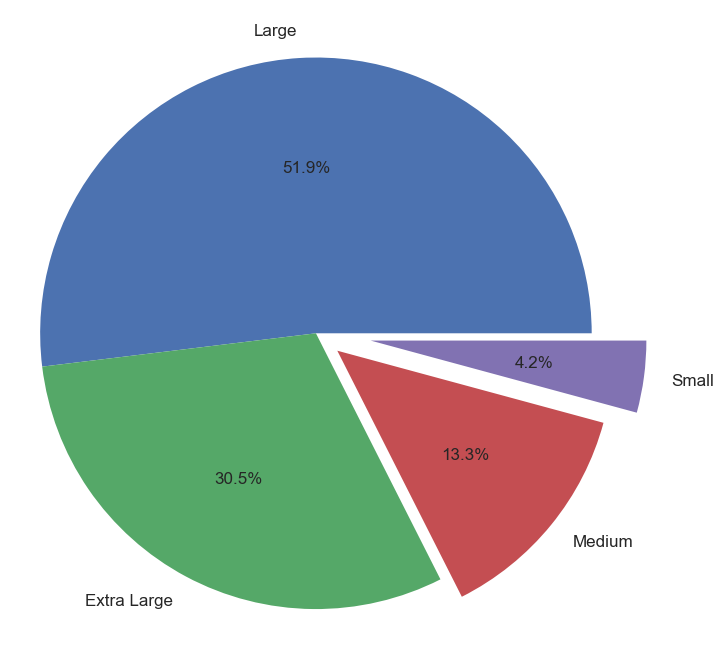

In [48]:
explode = (0, 0, 0.1, 0.2)
merged_ranking_df['Size'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(12,12), fontsize=17, explode = explode)

plt.ylabel("")
plt.axis('equal')
plt.show()

With the following boxplots we want to identify outliers within each region, and see if there is a difference in the ratio depending on the region of the university. 

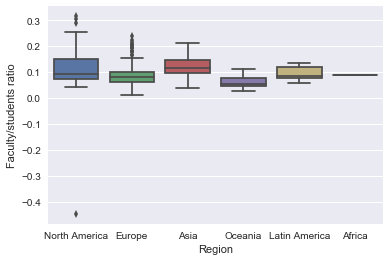

In [49]:
sns.boxplot(x='Region', y='Faculty/students ratio', data=merged_ranking_df)

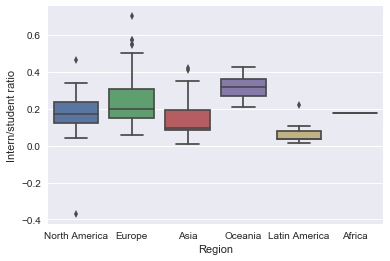

In [50]:
sns.boxplot(x='Region', y='Intern/student ratio', data=merged_ranking_df);

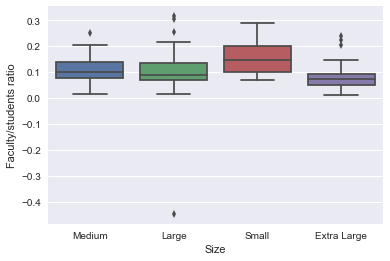

In [51]:
sns.boxplot(x='Size', y='Faculty/students ratio', data=merged_ranking_df);

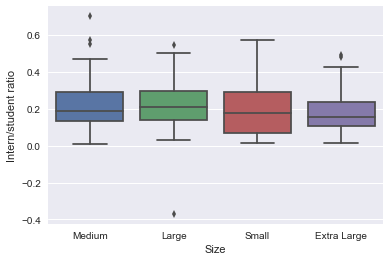

In [52]:
sns.boxplot(x='Size', y='Intern/student ratio', data=merged_ranking_df);

Now, classify universities in [2,3,4] groups depending on their internationality ratio, and plot different numbers of students, number of staff, and faculty/student ratio to see if there's any correlation (?).

TODO: The upcoming code is shitty, I just wanted to check the plots.

In [53]:
median_internationality = merged_ranking_df['Intern/student ratio'].median()
merged_ranking_df['Internationality2'] = merged_ranking_df['Intern/student ratio'].apply(lambda x: 'International' if x>median_internationality else 'Not international')

quantiles_int = merged_ranking_df['Intern/student ratio'].quantile([.33, .66])
merged_ranking_df['Internationality3'] = merged_ranking_df['Intern/student ratio'].apply(lambda x: 'Not international' if x<quantiles_int[.33] else 'International' if x<quantiles_int[.66] else 'Very international')

quantiles_int = merged_ranking_df['Intern/student ratio'].quantile([.25, .5, .75])
merged_ranking_df['Internationality4'] = merged_ranking_df['Intern/student ratio'].apply(lambda x: 'Not' if x<quantiles_int[.25] else 'A bit' if x<quantiles_int[.5] else 'Quite' if x<quantiles_int[.75] else 'Very')

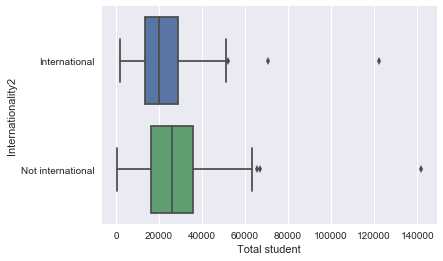

In [54]:
sns.boxplot(x='Total student', y='Internationality2', data=merged_ranking_df);

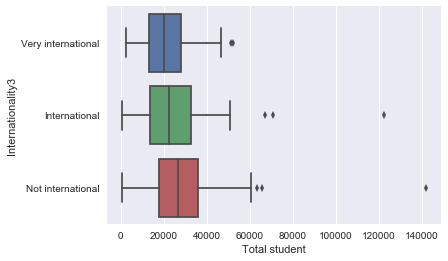

In [55]:
sns.boxplot(x='Total student', y='Internationality3', data=merged_ranking_df);

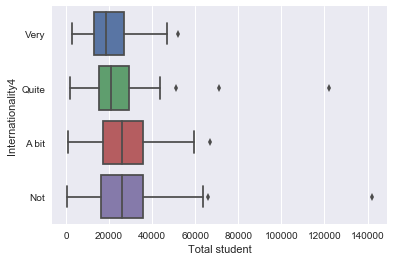

In [56]:
sns.boxplot(x='Total student', y='Internationality4', data=merged_ranking_df);

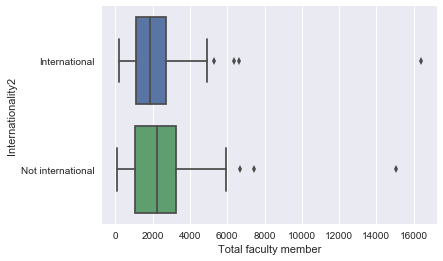

In [57]:
sns.boxplot(x='Total faculty member', y='Internationality2', data=merged_ranking_df);

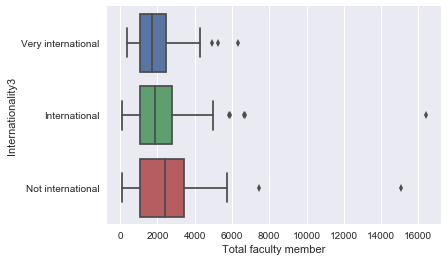

In [58]:
sns.boxplot(x='Total faculty member', y='Internationality3', data=merged_ranking_df);

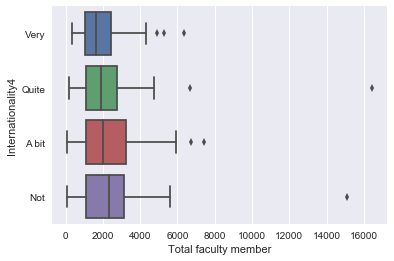

In [59]:
sns.boxplot(x='Total faculty member', y='Internationality4', data=merged_ranking_df);

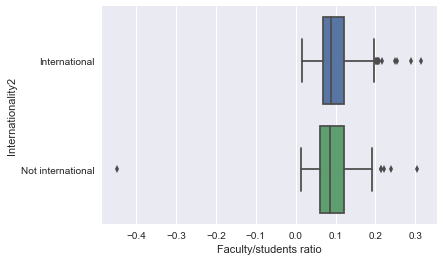

In [60]:
sns.boxplot(x='Faculty/students ratio', y='Internationality2', data=merged_ranking_df);

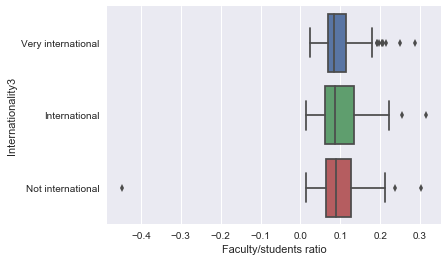

In [61]:
sns.boxplot(x='Faculty/students ratio', y='Internationality3', data=merged_ranking_df);

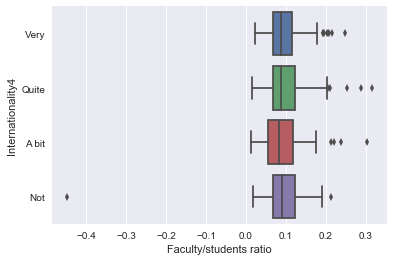

In [62]:
sns.boxplot(x='Faculty/students ratio', y='Internationality4', data=merged_ranking_df);

In [63]:
merged_ranking_df[['Rank_QS', 'Rank_TM', 'Region', 'Total student', 'International student', 'Total faculty member', 'Faculty/students ratio', 'Intern/student ratio']].corr()

,Rank_QS,Rank_TM,Total student,International student,Total faculty member,Faculty/students ratio,Intern/student ratio
Rank_QS,1.000000,0.730052,-0.037535,-0.318052,-0.263763,-0.245157,-0.324426
Rank_TM,0.730052,1.000000,-0.145325,-0.317904,-0.342564,-0.172691,-0.179529
Total student,-0.037535,-0.145325,1.000000,0.557633,0.730764,-0.221486,-0.180020
International student,-0.318052,-0.317904,0.557633,1.000000,0.396490,-0.177399,0.512861
Total faculty member,-0.263763,-0.342564,0.730764,0.396490,1.000000,0.306055,-0.120531
Faculty/students ratio,-0.245157,-0.172691,-0.221486,-0.177399,0.306055,1.000000,0.173669
Intern/student ratio,-0.324426,-0.179529,-0.180020,0.512861,-0.120531,0.173669,1.000000


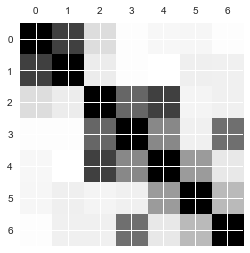

In [64]:
#plt.matshow(merged_ranking_df[['International faculty member', 'Rank_QS', 'Region', 'Rank_TM', 'Total student', 'International student', 'Total faculty member', 'Faculty/students ratio', 'Intern/student ratio']].corr())
plt.matshow(merged_ranking_df[['Rank_QS', 'Rank_TM', 'Region', 'Total student', 'International student', 'Total faculty member', 'Faculty/students ratio', 'Intern/student ratio']].corr())

Summary of this last part and TODOs:
* We might want to get a numeric ranking, so that we can check the correlation between the positions in the rankings and the other variables. This could be achieved by saving the order of the rows as the rank in the parsing.
* I don't know what to do with the NaNs. Maybe the best thing is to ignore those with masks, or try to guess them from similar universities (would be more difficult though). As long as we're ignoring them, I think we should be able to plot everything else without them.
* I couldn't conclude important things from the boxplots, at least nothing (IMO) that we can use for Task 5. Bear in mind that we had `-1` all over the place...

## Task 5 - 